In [1]:
import os
import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import pickle
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
!wget -q -P /kaggle/working/flickr8k https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q -P /kaggle/working/flickr8k https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -q -o /kaggle/working/flickr8k/Flickr8k_Dataset.zip -d /kaggle/working/flickr8k/
!unzip -q -o /kaggle/working/flickr8k/Flickr8k_text.zip -d /kaggle/working/flickr8k/

In [5]:
DATA_DIR = "/kaggle/working/flickr8k/Flickr8k"
IMAGES_DIR = "/kaggle/working/flickr8k/Flicker8k_Dataset"
CAPTIONS_FILE = "/kaggle/working/flickr8k/Flickr8k.token.txt"

In [6]:
OUTPUT_DIR = "/kaggle/working/output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [7]:
# Parameters
BATCH_SIZE = 64
NUM_WORKERS = 64
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 3
NUM_HEADS = 8
DROPOUT = 0.1
LEARNING_RATE = 3e-4
EPOCHS = 20
MAX_LEN = 50 

In [8]:
# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
# Data preparation functions
def load_captions(captions_file):
    """
    Load captions from file with improved error handling for various formats
    """
    captions_dict = {}
    
    # First try standard CSV/TSV parsing approaches
    try:
        try:
            # Try comma delimiter
            captions_df = pd.read_csv(captions_file, delimiter=',', on_bad_lines='skip')
        except:
            # Try tab delimiter
            captions_df = pd.read_csv(captions_file, delimiter='\t', on_bad_lines='skip')
        
        # Check if we have at least 2 columns (image name and caption)
        if len(captions_df.columns) >= 2:
            image_col = captions_df.columns[0]  # First column should be image name
            caption_col = captions_df.columns[1]  # Second column should be caption
            
            for _, row in captions_df.iterrows():
                img_name = str(row[image_col]).split('#')[0]  # Remove caption number if present
                caption = str(row[caption_col]).lower()
                
                # Clean caption
                caption = re.sub(r'[^\w\s]', '', caption)  # Remove punctuation
                caption = re.sub(r'\s+', ' ', caption).strip()  # Remove extra spaces
                
                if img_name not in captions_dict:
                    captions_dict[img_name] = []
                captions_dict[img_name].append(caption)
            
            return captions_dict
    except Exception as e:
        print(f"Standard parsing failed: {e}. Trying manual parsing...")
    
    # If standard parsing failed, try manual parsing
    try:
        with open(captions_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        # Try to determine the file format
        if len(lines) > 0:
            # Check first few non-empty lines to determine format
            for line in lines[:10]:
                if line.strip():
                    # Check for Flickr8k standard format: image_name#id caption
                    if '#' in line:
                        # Format appears to be: image_name#id caption
                        for line in lines:
                            if line.strip():
                                parts = line.strip().split(' ', 1)
                                if len(parts) == 2:
                                    img_parts = parts[0].split('#')
                                    img_name = img_parts[0]
                                    caption = parts[1].lower()
                                    
                                    # Clean caption
                                    caption = re.sub(r'[^\w\s]', '', caption) 
                                    caption = re.sub(r'\s+', ' ', caption).strip()
                                    
                                    if img_name not in captions_dict:
                                        captions_dict[img_name] = []
                                    captions_dict[img_name].append(caption)
                    else:
                        # Try a simple space-based split (image_name caption)
                        for line in lines:
                            if line.strip():
                                parts = line.strip().split(' ', 1)
                                if len(parts) == 2:
                                    img_name = parts[0]
                                    caption = parts[1].lower()
                                    
                                    # Clean caption
                                    caption = re.sub(r'[^\w\s]', '', caption)
                                    caption = re.sub(r'\s+', ' ', caption).strip()
                                    
                                    if img_name not in captions_dict:
                                        captions_dict[img_name] = []
                                    captions_dict[img_name].append(caption)
                    break
    except Exception as e:
        print(f"Manual parsing also failed: {e}")
        
    # If still no captions, try one more approach for COCO-style format
    if not captions_dict:
        try:
            import json
            with open(captions_file, 'r') as f:
                data = json.load(f)
            
            if 'annotations' in data:
                # COCO format
                img_id_to_filename = {}
                if 'images' in data:
                    for img in data['images']:
                        img_id_to_filename[img['id']] = img['file_name']
                
                for ann in data['annotations']:
                    img_id = ann['image_id']
                    img_name = img_id_to_filename.get(img_id, str(img_id))
                    caption = ann['caption'].lower()
                    
                    # Clean caption
                    caption = re.sub(r'[^\w\s]', '', caption)
                    caption = re.sub(r'\s+', ' ', caption).strip()
                    
                    if img_name not in captions_dict:
                        captions_dict[img_name] = []
                    captions_dict[img_name].append(caption)
        except:
            pass
    
    # Last resort: Create dummy captions if still empty
    if not captions_dict:
        print("WARNING: Could not parse captions file. Creating dummy captions.")
        # Create dummy captions for all images in the directory
        if os.path.exists(IMAGES_DIR):
            for img_file in os.listdir(IMAGES_DIR):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):
                    captions_dict[img_file] = ["a photo"]
    
    return captions_dict

In [10]:
def build_vocab(captions_dict, threshold=4):
    word_counts = Counter()
    
    # Count words
    for img_name, captions in captions_dict.items():
        for caption in captions:
            word_counts.update(caption.split())
    
    # Filter words below threshold
    words = [word for word, count in word_counts.items() if count >= threshold]
    
    # Create vocabulary
    vocab = {
        '<pad>': 0,  # Padding token
        '<start>': 1,  # Start of sentence token
        '<end>': 2,  # End of sentence token
        '<unk>': 3,  # Unknown token
    }
    
    # Add words to vocabulary
    vocab.update({word: i + 4 for i, word in enumerate(words)})
    
    return vocab, {v: k for k, v in vocab.items()}

In [11]:
def split_dataset(captions_dict, train_ratio=0.8, val_ratio=0.1):
    # Get unique image names
    image_names = list(captions_dict.keys())
    random.shuffle(image_names)
    
    # Split indices
    n_train = int(len(image_names) * train_ratio)
    n_val = int(len(image_names) * val_ratio)
    
    # Split image names
    train_names = image_names[:n_train]
    val_names = image_names[n_train:n_train + n_val]
    test_names = image_names[n_train + n_val:]
    
    # Create split dictionaries
    train_dict = {k: captions_dict[k] for k in train_names}
    val_dict = {k: captions_dict[k] for k in val_names}
    test_dict = {k: captions_dict[k] for k in test_names}
    
    return train_dict, val_dict, test_dict

In [12]:
class Flickr8kDataset(Dataset):
    def __init__(self, captions_dict, imgs_dir, vocab, transform=None, max_len=50):
        self.imgs_dir = imgs_dir
        self.vocab = vocab
        self.transform = transform
        self.max_len = max_len
        
        self.data = []
        for img_name, captions in captions_dict.items():
            img_path = os.path.join(imgs_dir, img_name)
            if os.path.exists(img_path):
                for caption in captions:
                    self.data.append((img_path, caption))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, caption = self.data[idx]
        
        # Load and transform image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Convert caption to tensor
        tokens = ['<start>'] + caption.split() + ['<end>']
        caption = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]
        
        # Truncate or pad caption
        if len(caption) > self.max_len:
            caption = caption[:self.max_len]
        
        return image, torch.tensor(caption)

In [13]:
def collate_fn(batch):
    # Sort batch by caption length in descending order
    batch.sort(key=lambda x: len(x[1]), reverse=True)
    
    images, captions = zip(*batch)
    
    # Stack images
    images = torch.stack(images, 0)
    
    # Pad captions
    lengths = [len(cap) for cap in captions]
    targets = pad_sequence(captions, batch_first=True, padding_value=0)
    
    return images, targets, lengths

In [14]:
# Model Architecture
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        # Use pretrained ResNet-50
        resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        
        # Remove last FC layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        
        # Add projection layer
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, images):
        # Extract features from ResNet
        with torch.no_grad():
            features = self.resnet(images)
        
        # Flatten and project features
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        features = self.bn(features)
        features = self.dropout(features)
        
        return features

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        # Create positional encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        # Register buffer (persistent state)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # Add positional encoding to input
        x = x + self.pe[:, :x.size(1)]
        return x

In [16]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, num_heads, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        
        # Word embedding
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size)
        
        # Transformer decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_size,
            nhead=num_heads,
            dim_feedforward=hidden_size,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_layers
        )
        
        # Output layer
        self.fc = nn.Linear(embed_size, vocab_size)
        
    def forward(self, features, captions, caption_mask=None):
        # features: [batch_size, embed_size]
        # captions: [batch_size, caption_length]
        
        # Expand features to match transformer's expected memory shape
        memory = features.unsqueeze(1)  # [batch_size, 1, embed_size]
        
        # Embed captions
        embeddings = self.embed(captions)  # [batch_size, caption_length, embed_size]
        embeddings = self.positional_encoding(embeddings)
        
        # Create masks for transformer
        # Target mask (causal mask)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(
            sz=captions.size(1),
            device=captions.device
        )
        
        # Memory padding mask (attention mask for encoder output)
        memory_key_padding_mask = None  # No padding in memory
        
        # Transformer decoder forward pass
        output = self.transformer_decoder(
            tgt=embeddings,
            memory=memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=caption_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )
        
        # Project to vocabulary size
        output = self.fc(output)
        
        return output

In [17]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, num_heads, dropout=0.1):
        super(ImageCaptioningModel, self).__init__()
        
        # Image encoder
        self.encoder = EncoderCNN(embed_size)
        
        # Caption decoder
        self.decoder = TransformerDecoder(
            vocab_size=vocab_size,
            embed_size=embed_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            num_heads=num_heads,
            dropout=dropout
        )
        
    def forward(self, images, captions, caption_mask=None):
        # Encode images
        features = self.encoder(images)
        
        # Decode captions
        outputs = self.decoder(features, captions, caption_mask)
        
        return outputs
    
    def generate_caption(self, image, vocab_idx2word, max_len=50, beam_size=3):
        """Generate caption with beam search"""
        with torch.no_grad():
            # Encode image
            feature = self.encoder(image.unsqueeze(0))  # [1, embed_size]
            
            # Initialize beams
            beams = [([1], 0)]  # ([<start>], score)
            complete_captions = []
            
            # Beam search loop
            for _ in range(max_len):
                candidates = []
                
                # Expand each beam
                for seq, score in beams:
                    if seq[-1] == 2:  # <end> token
                        complete_captions.append((seq, score))
                        continue
                    
                    # Convert caption to tensor
                    caption_tensor = torch.tensor(seq, device=feature.device).unsqueeze(0)
                    
                    # Predict next word
                    output = self.decoder(feature, caption_tensor)  # [1, caption_len, vocab_size]
                    output = output[0, -1]  # Last prediction [vocab_size]
                    
                    # Get top-k predictions
                    probs = F.softmax(output, dim=0)
                    top_k_probs, top_k_idx = probs.topk(beam_size)
                    
                    # Add to candidates
                    for i in range(beam_size):
                        word_idx = top_k_idx[i].item()
                        new_score = score - torch.log(top_k_probs[i]).item()  # Negative log likelihood
                        candidates.append((seq + [word_idx], new_score))
                
                # Select top-k beams
                candidates.sort(key=lambda x: x[1])
                beams = candidates[:beam_size]
                
                # Early stopping if all beams end
                if all(beam[0][-1] == 2 for beam in beams):
                    complete_captions.extend(beams)
                    break
            
            # Sort complete captions by score
            if complete_captions:
                complete_captions.sort(key=lambda x: x[1])
                best_caption = complete_captions[0][0]
            else:
                best_caption = beams[0][0]
            
            # Remove <start> and <end> tokens
            if best_caption[-1] == 2:  # <end> token
                best_caption = best_caption[1:-1]
            else:
                best_caption = best_caption[1:]
            
            # Convert token IDs to words
            caption_words = [vocab_idx2word.get(idx, '<unk>') for idx in best_caption]
            return ' '.join(caption_words)

In [18]:
def create_caption_mask(lengths, device):
    """Create padding mask for captions"""
    max_len = max(lengths)
    mask = torch.zeros(len(lengths), max_len, device=device, dtype=torch.bool)
    for i, length in enumerate(lengths):
        mask[i, length:] = True
    return mask

In [19]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch_idx, (images, captions, lengths) in enumerate(dataloader):
        images = images.to(device)
        captions = captions.to(device)
        
        # Create padding mask
        caption_mask = create_caption_mask(lengths, device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images, captions[:, :-1], caption_mask[:, :-1])
        
        # Reshape outputs and targets for loss calculation
        outputs = outputs.reshape(-1, outputs.shape[-1])
        targets = captions[:, 1:].reshape(-1)
        
        # Calculate loss (ignore padding)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Log progress
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}")
    
    return total_loss / len(dataloader)

In [20]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch_idx, (images, captions, lengths) in enumerate(dataloader):
            images = images.to(device)
            captions = captions.to(device)
            
            # Create padding mask
            caption_mask = create_caption_mask(lengths, device)
            
            # Forward pass
            outputs = model(images, captions[:, :-1], caption_mask[:, :-1])
            
            # Reshape outputs and targets for loss calculation
            outputs = outputs.reshape(-1, outputs.shape[-1])
            targets = captions[:, 1:].reshape(-1)
            
            # Calculate loss (ignore padding)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
               epochs, device, save_dir):
    """Train the model"""
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        start_time = time.time()
        
        # Train
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        
        # Validate
        val_loss = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            }, os.path.join(save_dir, 'best_model.pth'))
        
        # Save checkpoint
        if (epoch+1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth'))
        
        # Print epoch stats
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs} completed in {elapsed_time:.2f}s")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Save loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'loss_curves.png'))

    torch.save(model, os.path.join(save_dir, "best_model.pt"))
    
    return train_losses, val_losses

In [22]:
def calculate_bleu(model, dataloader, vocab_idx2word, device, beam_size=3):
    """Calculate BLEU score"""
    from nltk.translate.bleu_score import corpus_bleu
    
    model.eval()
    references = []
    hypotheses = []
    
    with torch.no_grad():
        for batch_idx, (images, captions, _) in enumerate(dataloader):
            images = images.to(device)
            
            # Generate captions
            for i in range(len(images)):
                # Convert reference caption
                reference = [[vocab_idx2word[idx.item()] for idx in captions[i] if idx.item() > 0]]
                # Remove <start> and <end> tokens if present
                if reference[0][0] == '<start>':
                    reference[0] = reference[0][1:]
                if reference[0][-1] == '<end>':
                    reference[0] = reference[0][:-1]
                
                # Generate hypothesis
                hypothesis = model.generate_caption(images[i], vocab_idx2word, beam_size=beam_size)
                hypothesis = hypothesis.split()
                
                references.append([reference[0]])
                hypotheses.append(hypothesis)
            
            # Print progress
            if batch_idx % 10 == 0:
                print(f"Evaluated {batch_idx}/{len(dataloader)} batches")
    
    # Calculate BLEU scores
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu1, bleu4

In [23]:
def visualize_predictions(model, dataloader, vocab_idx2word, device, num_samples=5):
    """Visualize model predictions"""
    model.eval()
    
    # Get a batch of data
    images, captions, _ = next(iter(dataloader))
    images = images.to(device)
    
    # Choose random samples
    indices = random.sample(range(len(images)), min(num_samples, len(images)))
    
    # Create a figure
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 5*num_samples))
    
    for i, idx in enumerate(indices):
        # Get image and reference caption
        image = images[idx]
        reference = ' '.join([vocab_idx2word[idx.item()] for idx in captions[idx] if idx.item() > 0])
        # Remove <start> and <end> tokens if present
        reference = reference.replace('<start> ', '').replace(' <end>', '')
        
        # Generate prediction
        prediction = model.generate_caption(image, vocab_idx2word)
        
        # Denormalize image
        img = image.cpu().clone()
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        
        # Plot
        ax = axes[i] if num_samples > 1 else axes
        ax.imshow(img)
        ax.set_title(f"Reference: {reference}\nPrediction: {prediction}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'sample_predictions.png'))

Loading and preparing data...
Vocabulary size: 3071
Train dataset size: 32358
Validation dataset size: 4045
Test dataset size: 4050
Building model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 208MB/s]


Training model...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Batch 0/506, Loss: 8.2029
Batch 10/506, Loss: 6.7367
Batch 20/506, Loss: 6.0554
Batch 30/506, Loss: 5.6686
Batch 40/506, Loss: 5.3861
Batch 50/506, Loss: 5.3779
Batch 60/506, Loss: 5.2362
Batch 70/506, Loss: 5.3398
Batch 80/506, Loss: 5.2063
Batch 90/506, Loss: 4.9580
Batch 100/506, Loss: 4.9832
Batch 110/506, Loss: 4.7561
Batch 120/506, Loss: 4.7244
Batch 130/506, Loss: 4.7108
Batch 140/506, Loss: 4.5569
Batch 150/506, Loss: 4.7827
Batch 160/506, Loss: 4.4210
Batch 170/506, Loss: 4.4864
Batch 180/506, Loss: 4.4752
Batch 190/506, Loss: 4.3119
Batch 200/506, Loss: 4.1178
Batch 210/506, Loss: 4.2331
Batch 220/506, Loss: 4.1529
Batch 230/506, Loss: 4.1628
Batch 240/506, Loss: 4.0124
Batch 250/506, Loss: 4.3146
Batch 260/506, Loss: 4.0470
Batch 270/506, Loss: 4.2215
Batch 280/506, Loss: 4.0743
Batch 290/506, Loss: 3.8675
Batch 300/506, Loss: 3.9462
Batch 310/506, Loss: 4.0595
Batch 320/506, Loss: 4.1797
Batch 330/506, Loss: 3.8399
Batch 340/506, Loss: 4.0911
Batch 350/506, Loss: 3.9216
Bat

<ipython-input-24-7cb87b0a8758>:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(OUTPUT_DIR, 'best_model.pth'))


Evaluating model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Evaluated 0/64 batches
Evaluated 10/64 batches
Evaluated 20/64 batches
Evaluated 30/64 batches
Evaluated 40/64 batches
Evaluated 50/64 batches
Evaluated 60/64 batches
BLEU-1: 0.2716, BLEU-4: 0.0549
Done!


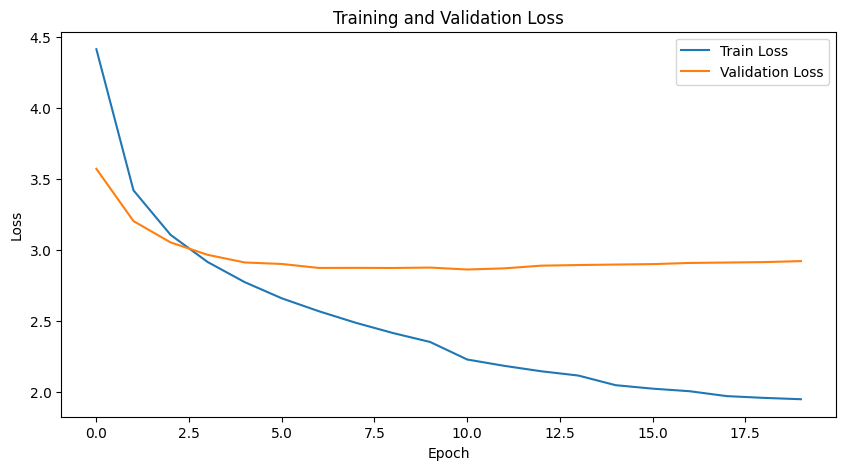

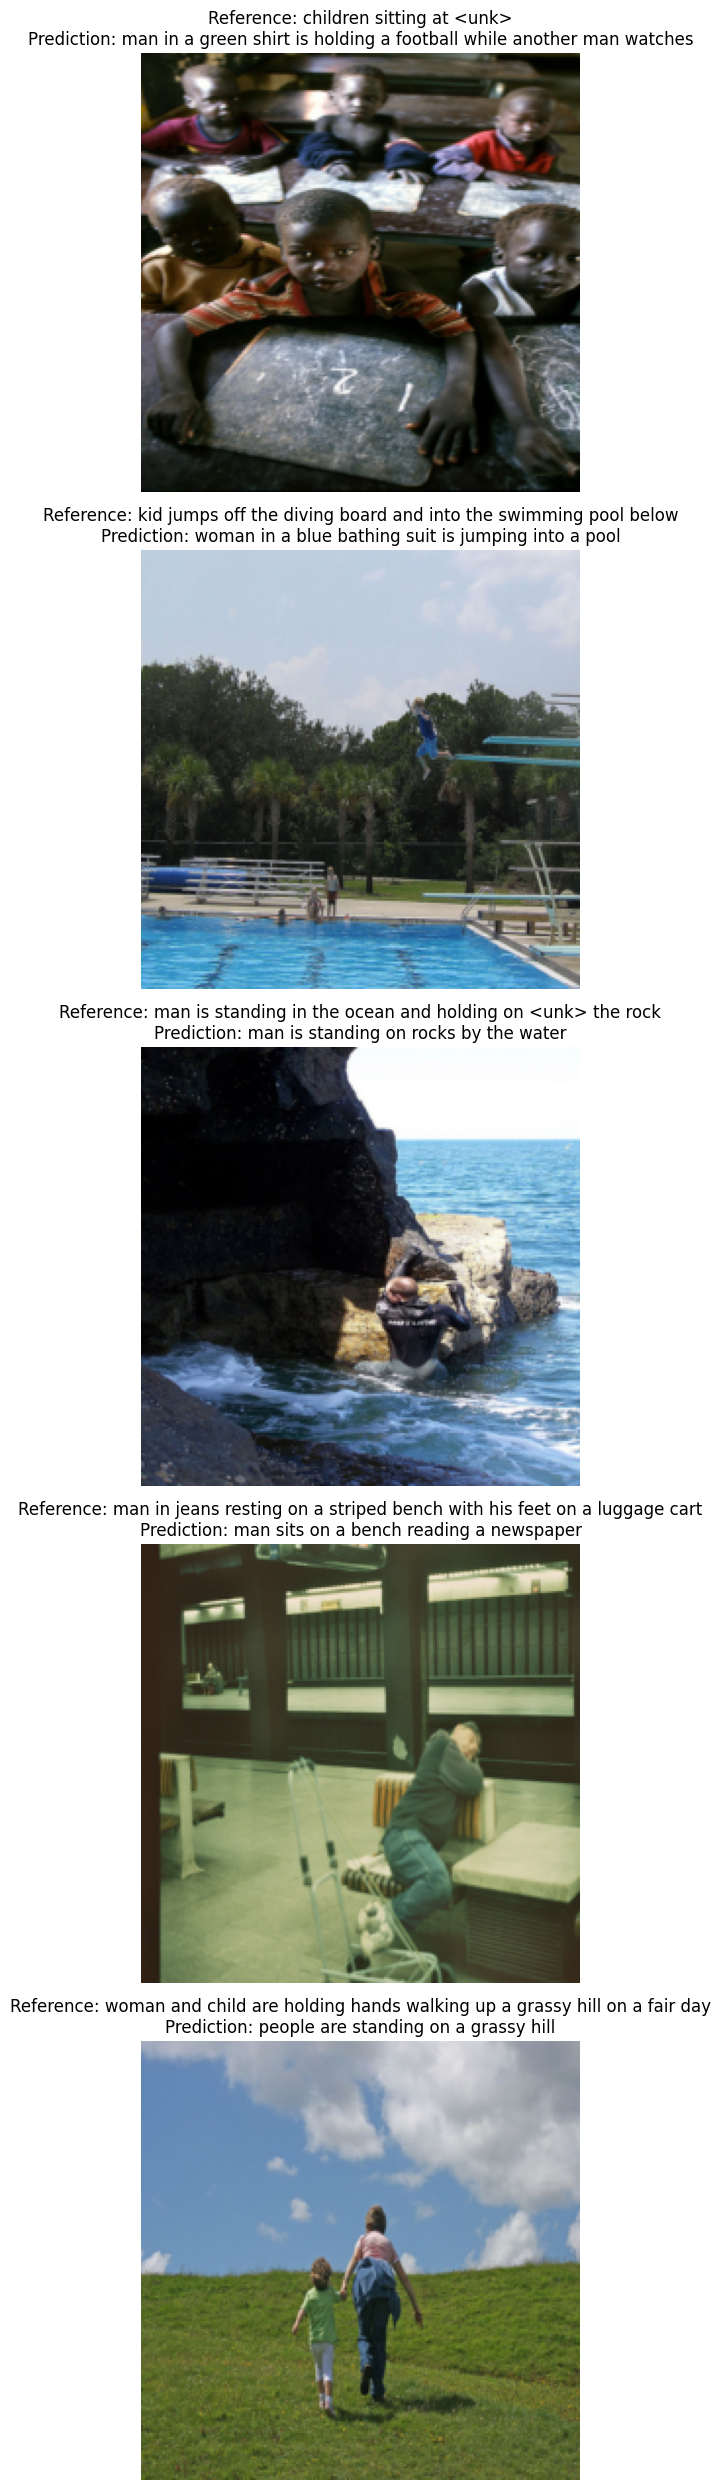

In [24]:
# Main execution
def main():
    print("Loading and preparing data...")
    # Load captions and build vocabulary
    captions_dict = load_captions(CAPTIONS_FILE)
    train_dict, val_dict, test_dict = split_dataset(captions_dict)
    
    # Build vocabulary from training set
    vocab_word2idx, vocab_idx2word = build_vocab(train_dict)
    vocab_size = len(vocab_word2idx)
    print(f"Vocabulary size: {vocab_size}")
    
    # Save vocabulary
    with open(os.path.join(OUTPUT_DIR, 'vocab.pkl'), 'wb') as f:
        pickle.dump((vocab_word2idx, vocab_idx2word), f)
    
    # Create datasets and dataloaders
    train_dataset = Flickr8kDataset(
        train_dict, IMAGES_DIR, vocab_word2idx, transform, MAX_LEN
    )
    val_dataset = Flickr8kDataset(
        val_dict, IMAGES_DIR, vocab_word2idx, transform, MAX_LEN
    )
    test_dataset = Flickr8kDataset(
        test_dict, IMAGES_DIR, vocab_word2idx, transform, MAX_LEN
    )
    
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        collate_fn=collate_fn
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        collate_fn=collate_fn
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        collate_fn=collate_fn
    )
    
    print("Building model...")
    # Initialize model
    model = ImageCaptioningModel(
        embed_size=EMBED_SIZE,
        hidden_size=HIDDEN_SIZE,
        vocab_size=vocab_size,
        num_layers=NUM_LAYERS,
        num_heads=NUM_HEADS,
        dropout=DROPOUT
    ).to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    
    print("Training model...")
    # Train model
    train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=EPOCHS,
        device=device,
        save_dir=OUTPUT_DIR
    )
    
    # Load best model
    checkpoint = torch.load(os.path.join(OUTPUT_DIR, 'best_model.pth'))
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print("Evaluating model...")
    # Calculate BLEU scores
    bleu1, bleu4 = calculate_bleu(model, test_loader, vocab_idx2word, device)
    print(f"BLEU-1: {bleu1:.4f}, BLEU-4: {bleu4:.4f}")
    
    # Visualize predictions
    visualize_predictions(model, test_loader, vocab_idx2word, device)
    
    print("Done!")

if __name__ == "__main__":
    main()

In [ ]:
!zip -r /kaggle/working/output.zip /kaggle/working/*

  adding: kaggle/working/flickr8k/ (stored 0%)
  adding: kaggle/working/flickr8k/ExpertAnnotations.txt (deflated 80%)
  adding: kaggle/working/flickr8k/Flickr_8k.testImages.txt (deflated 50%)
  adding: kaggle/working/flickr8k/Flickr_8k.devImages.txt (deflated 50%)
  adding: kaggle/working/flickr8k/Flickr8k.token.txt (deflated 74%)
  adding: kaggle/working/flickr8k/__MACOSX/ (stored 0%)
  adding: kaggle/working/flickr8k/__MACOSX/._Flickr8k.lemma.token.txt (deflated 36%)
  adding: kaggle/working/flickr8k/__MACOSX/._Flicker8k_Dataset (deflated 36%)
  adding: kaggle/working/flickr8k/__MACOSX/Flicker8k_Dataset/ (stored 0%)
  adding: kaggle/working/flickr8k/__MACOSX/Flicker8k_Dataset/._3607969989_68cc411493.jpg (deflated 36%)
  adding: kaggle/working/flickr8k/__MACOSX/Flicker8k_Dataset/._3490044563_8eb551ef59.jpg (deflated 36%)
  adding: kaggle/working/flickr8k/__MACOSX/Flicker8k_Dataset/._214543992_ce6c0d9f9b.jpg (deflated 36%)
  adding: kaggle/working/flickr8k/__MACOSX/Flicker8k_Dataset/._